## Colour Palettes

In this experiment, we're going to try and match images to a colour palette, a little bit like the Google Arts and Culture Experiment here:
https://artsexperiments.withgoogle.com/artpalette/
or the Europeana colour viewer here:
https://www.europeana.eu/portal/en/explore/colours.html 


To do this, we're first going to download a large number of images into the ImageData folder. 

In [36]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
import skimage
from skimage import io, transform, color
import numpy as np

In [2]:
WGACatalog = []
with open('../ImageData/WGA/WebGalleryCatalog.csv', 'rt', encoding = "ISO-8859-1") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';', quotechar="'")
    for row in spamreader:
        WGACatalog.append(row)
print('Downloaded catalogue of ' + str(len(WGACatalog)-1) + ' elements. ')

Downloaded catalogue of 45461 elements. 


In [3]:
# Each entry in the catalog contains a URL pointing to the entry on the Web Gallery of Art's (old) webpage, 
# something like: https://www.wga.hu/html/a/aachen/allegory.html 
# We want to change it to something like: https://www.wga.hu/art/a/aachen/allegory.jpg 
# using some predictable text replacements, which is very easy to do in Python:

ImURLs = []
for WGAC in WGACatalog[1:]:
    ImURLs.append(WGAC[6].replace('/html/','/art/').replace('.html','.jpg'))

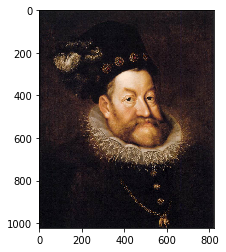

In [4]:
# Now we check that our 

plt.imshow(io.imread(ImURLs[3]))

# Downloading image data

We're now going to download a large number of images from the Web Gallery of Art - say, a kiloimage (one thousand images). Since this will probably take some time, we'll want a progress bar to be able to see how fast we're going. The most widely-used progress bar is called TQDM, and can be installed through Pip or Conda. First select the kernel we're using. Type into Terminal or Jupyter Console: 

`source activate esu2018` (Mac/Linux) or just `activate esu2018` (Windows)

And then install TQDM:

`conda install tqdm`

As well as PlotLy, a Python plotting environment with better 3D support:

`conda install plotly`

You'll normally be asked to confirm the installation (press 'y' and Enter) before installation takes place. You might need to restart the kernel (on the menu at the top of this page, Kernel > Restart) for the changes to take effect. 

In [265]:
import tqdm

In [276]:
j = 0

NPaintings = 500

for i in tqdm.tqdm(range(NPaintings)):
    io.imsave('../ImageData/WGA/Images' + str(i).zfill(5) + '.jpg', io.imread(ImURLs[i]))

100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


In [277]:
# Now we've downloaded all the images, let's load them all into memory: 
AllIms = np.zeros((NPaintings,256,256,3))
for i in tqdm.tqdm(range(NPaintings)):
    AllIms[i,:,:,:] = transform.resize(io.imread('../ImageData/WGA/Images' + str(i).zfill(5) + '.jpg'),(256,256,3))

  0%|          | 0/500 [00:00<?, ?it/s]/home/impett/anaconda3/envs/esu2018/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning:

The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.

/home/impett/anaconda3/envs/esu2018/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.

100%|██████████| 500/500 [00:18<00:00, 26.89it/s]


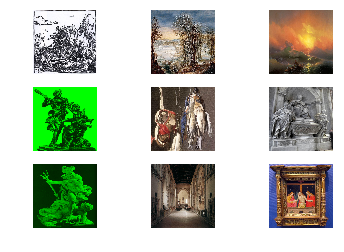

In [279]:
## Let's open a few of these images, to check they're the right sort of thing! 
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(AllIms[np.random.randint(NPaintings),:,:,:])
    plt.axis('off')

You might see some images are in green - those are black and white images! We'll now try and create a colour palette for each image. This is normally done by K-Means clustering in colour space. To do this, we're going to use the K Means function from Scikit-Learn, the machine learning library. K-means clustering is useful for a wide range of other scenarios - see https://en.wikipedia.org/wiki/K-means_clustering 

We're going to be clustering not in RGB colour space, but in LAB, which is closer to perceptual colour - see https://en.wikipedia.org/wiki/CIELAB_color_space

In [280]:
from sklearn import cluster

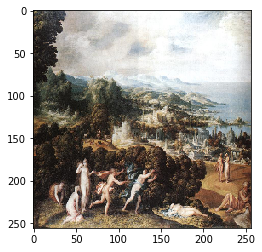

In [281]:
# Let's go through the process on a single image first... 
TestIm = AllIms[15,:,:,:]
plt.imshow(TestIm)
# Now convert the image to LAB:
LABim = color.rgb2lab(TestIm)

In [282]:
# We now take just the A, B components of the LAB image (eliminating L, the lightness): 
ABim = LABim[:,:,1:]
# And now do some clustering, to find some quantised A-B values:
CX = cluster.KMeans(n_clusters=3)
Clusts = CX.fit_predict(ABim.reshape(256*256,2))

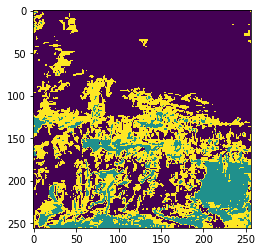

In [283]:
# Now visualise the clusters as applied to the original image:
plt.imshow(Clusts.reshape(256,256))

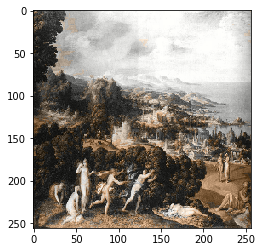

In [284]:
# Finally, we work out what these clusters correspond to in terms of visible colours: 
LABquant= LABim.copy()
for i in range(256):
    for j in range(256):
#         LABim[i,j,0] = 
        LABquant[i,j,1:] = CX.cluster_centers_[Clusts[i*256 + j]]
RGBquant = color.lab2rgb(LABquant)
plt.imshow(RGBquant)

Text(0.5,1,'Colour-Clustered Image')

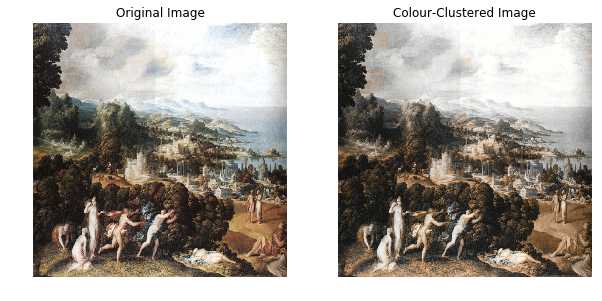

In [285]:
# Looks almost the same, right? Try side-by-side: 
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(TestIm)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(RGBquant)
plt.axis('off')
plt.title('Colour-Clustered Image')

# Writing a function

We can now write a function to do all the above steps; taking an image, clustering the colours, and returning a set of cluster colours in RGB. 

In [286]:
def colourPalette(TestIm, nClust=3):
    LABim = color.rgb2lab(TestIm)
    ABim = LABim[:,:,1:]
    CX = cluster.KMeans(n_clusters=nClust)
    iM = TestIm.shape[0]
    jM = TestIm.shape[1]
    Clusts = CX.fit_predict(ABim.reshape(iM*jM,2))
    palette = []
    for i in range(nClust):
        p = np.mean(LABim.reshape(iM*jM,3)[Clusts==i],axis=0)
        palette.append( color.lab2rgb(p.reshape(1,1,3))[0][0] )
    return palette

In [287]:
def showPalette(palette):
    nCols = len(palette)
    for i in range(nCols):
        plt.subplot(1,nCols,i+1)
        p = palette[i]
        plt.imshow(np.tile(p,(10,10,1)))
        plt.axis('off')
        

Now let's see if it works on some other images, for some other number of clusters... 

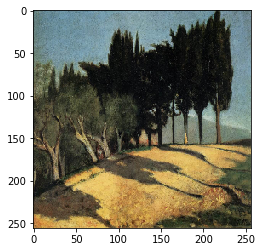

In [288]:
plt.imshow(AllIms[19,:,:,:])

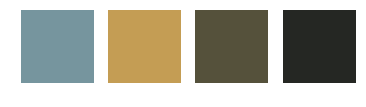

In [289]:
showPalette(colourPalette(AllIms[19,:,:,:],nClust=4))

Finally, let's try and look at our whole dataset, seeing how colours change for different images... 

In [290]:
allPalettes = []
for i in tqdm.tqdm(range(NPaintings)):
    allPalettes.append(colourPalette(AllIms[i,:,:,:]))
    

100%|██████████| 500/500 [04:15<00:00,  1.96it/s]


In [293]:
allPalettes[0]

[array([0.3327233 , 0.29599468, 0.29834037]),
 array([0.67423247, 0.56982749, 0.45782179]),
 array([0.53612981, 0.3686487 , 0.33443943])]

In [294]:
from mpl_toolkits.mplot3d import Axes3D
XYZ = np.asarray(allPalettes).reshape(NPaintings*3,3)

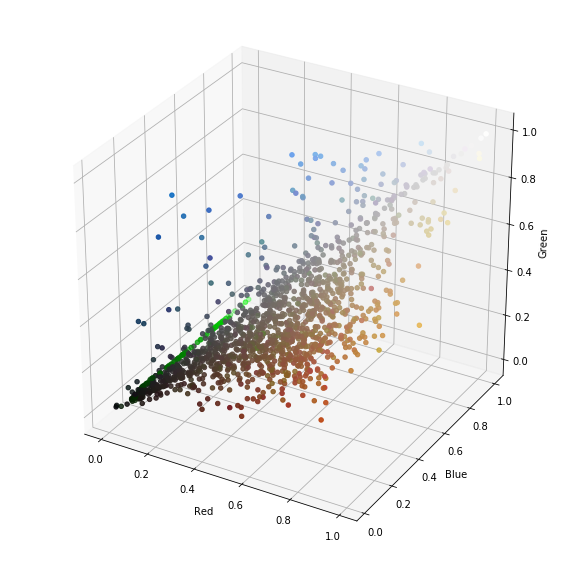

In [296]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(XYZ[:,0], XYZ[:,1], XYZ[:,2], c=XYZ, marker='o')

ax.set_xlabel('Red')
ax.set_ylabel('Blue')
ax.set_zlabel('Green');